Code for the midway progress report.  Should accomplish the following objectives:

 - Load data and identify useful features
 - Use decision trees to find optimal bins for all continuous features
 - Apply various transformations to continuous variables
 - Run linear regression model on full dataset with all engineered features
 - Visualize model performance

In [1]:
%matplotlib inline
import dataset
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.tree
import pydotplus

from IPython.display import Image
from io import StringIO
from tqdm import tqdm

# Load data and identify useful features

Connect to the database and query the data.

In [2]:
db = dataset.connect('postgres:///steam')

In [3]:
query = '''
SELECT
  steam_app_id,
  game_name,
  reviews_last_30_days,
  pct_positive_reviews_last_30_days,
  reviews_all_time,
  pct_positive_reviews_all_time,
  release_date,
  title,
  developer,
  publisher,
  num_achievements,
  full_price,
  metacritic_score,
  genres,
  details,
  tags
FROM
  game_crawl_view
WHERE
  is_dlc = FALSE
  AND pct_positive_reviews_all_time IS NOT NULL
  AND short_description IS NOT NULL
  AND short_description != ''
  AND long_description IS NOT NULL
  AND long_description != '';
'''

data = [r for r in db.query(query)]
df = pd.DataFrame(data)
df.index = df['steam_app_id']
df.drop('steam_app_id', axis=1, inplace=True)
display(df.head())
display(df.shape)

,game_name,reviews_last_30_days,pct_positive_reviews_last_30_days,reviews_all_time,pct_positive_reviews_all_time,release_date,title,developer,publisher,num_achievements,full_price,metacritic_score,genres,details,tags
steam_app_id,,,,,,,,,,,,,,,
10,Counter-Strike,745.0,96.0,39394,97.0,2000-11-01,Counter-Strike,Valve,Valve,NaN,9.99,88.0,[Action],"[Multi-player, Valve Anti-Cheat enabled]","[Action, FPS, Multiplayer, Shooter, Classic, T..."
20,Team Fortress Classic,35.0,71.0,1842,81.0,1999-04-01,Team Fortress Classic,Valve,Valve,NaN,4.99,NaN,[Action],"[Multi-player, Valve Anti-Cheat enabled]","[Classic, Shooter, Class-Based, Team-Based, Fi..."
60,Ricochet,18.0,72.0,1198,79.0,2000-11-01,Ricochet,Valve,Valve,NaN,4.99,NaN,[Action],"[Multi-player, Valve Anti-Cheat enabled]","[Action, FPS, Multiplayer, First-Person, Cyber..."
70,Half-Life,196.0,93.0,11792,96.0,1998-11-08,Half-Life,Valve,Valve,NaN,9.99,96.0,[Action],"[Single-player, Multi-player, Valve Anti-Cheat...","[FPS, Classic, Action, Sci-fi, Singleplayer, S..."
130,Half-Life: Blue Shift,37.0,86.0,1916,90.0,2001-06-01,Half-Life: Blue Shift,Gearbox Software,Valve,NaN,4.99,71.0,[Action],[Single-player],"[FPS, Action, Sci-fi, Singleplayer, Shooter, A..."


(11239, 15)

Create dummies for list variables (such as genre; each game can have multiple genres, where we really just need one-hot encodings for all genres).

In [4]:
def create_dummies_from_list(df, col, db_table):
    all_values = {r['descr'] for r in db[db_table].find()}
    agg_series = df[col].apply(lambda x: [] if x is None else x)
    df.drop(col, axis=1, inplace=True)
    for val in all_values:
        df['{}|{}'.format(col, val)] = agg_series.apply(lambda x: val in x)

create_dummies_from_list(df, 'genres', 'steam_genre')
create_dummies_from_list(df, 'details', 'steam_game_detail')
create_dummies_from_list(df, 'tags', 'steam_tag')

display(df.head())
display(df.shape)

,game_name,reviews_last_30_days,pct_positive_reviews_last_30_days,reviews_all_time,pct_positive_reviews_all_time,release_date,title,developer,publisher,num_achievements,...,tags|Ninja,tags|Racing,tags|Underwater,tags|Mars,tags|First-Person,tags|Trading Card Game,tags|RTS,tags|Drama,tags|Arena Shooter,tags|Trains
steam_app_id,,,,,,,,,,,,,,,,,,,,,
10,Counter-Strike,745.0,96.0,39394,97.0,2000-11-01,Counter-Strike,Valve,Valve,NaN,...,True,False,False,False,True,False,False,False,False,False
20,Team Fortress Classic,35.0,71.0,1842,81.0,1999-04-01,Team Fortress Classic,Valve,Valve,NaN,...,False,False,False,False,True,False,False,False,False,False
60,Ricochet,18.0,72.0,1198,79.0,2000-11-01,Ricochet,Valve,Valve,NaN,...,False,False,False,False,True,False,False,False,False,False
70,Half-Life,196.0,93.0,11792,96.0,1998-11-08,Half-Life,Valve,Valve,NaN,...,False,False,False,False,True,False,False,False,False,False
130,Half-Life: Blue Shift,37.0,86.0,1916,90.0,2001-06-01,Half-Life: Blue Shift,Gearbox Software,Valve,NaN,...,False,False,False,False,True,False,False,False,False,False


(11239, 409)

Create dummies for regular categorical variables.  However, these have way too many distinct values, so only save the one-hot encodings for values more frequent than 10 (i.e., only make a specific publisher a feature if they've published >= 10 games in our dataset).

In [5]:
def create_dummies(df, col, min_num=10):
    series = df[col]
    df.drop(col, axis=1, inplace=True)
    
    counts = series.value_counts()
    filtered_counts = counts[counts >= min_num]
    filtered_series = series.apply(lambda x: x if x in filtered_counts.index else np.NaN)
    return df.merge(pd.get_dummies(filtered_series, prefix=col, prefix_sep='|'), left_index=True, right_index=True)

df = create_dummies(df, 'publisher')
df = create_dummies(df, 'developer')

Some variables have missing values that should represent 0.  Make that replacement here.

In [6]:
for col in ['reviews_last_30_days', 'num_achievements', 'full_price']:
    df[col].fillna(value=0, inplace=True)

The timestamp probably won't be a useful feature, but convert it to a float so it's at least usable in case it becomes one.  There are only a few games with null release date (38); drop them to avoid fitting the model on a null timestamp.

In [7]:
df = df[~pd.isnull(df['release_date'])]

# Divide by 10^9 to get seconds since the epoch instead of nanoseconds
df.loc[:, 'release_date'] = (pd.to_datetime(df['release_date']).astype(np.int64) / 10**9).astype(np.float64)

Convert integer continuous variables to floats so they work well with our models later.

In [8]:
df.loc[:, 'reviews_all_time'] = df['reviews_all_time'].astype(np.float64)

Remove the outcome and other related vars from the set of features to prepare for analysis.

In [9]:
y = df['pct_positive_reviews_all_time']

for col in ('pct_positive_reviews_last_30_days', 'pct_positive_reviews_all_time',
            'game_name', 'title', 'metacritic_score'):
    df.drop(col, axis=1, inplace=True)

In [10]:
df_train, df_test, y_train, y_test = sklearn.model_selection.train_test_split(df, y, test_size=0.2,
                                                                              random_state=1337)

Final feature set for analysis (until text features are added):

In [11]:
display(df_train.shape)
display(df_test.shape)

(8960, 614)

(2241, 614)

# Use decision trees to find optimal bins for all continuous predictors

When dealing with continuous variables that have a nonlinear relationship with the outcome, sometimes setting up discrete bins is the best way to utilize the feature in the model.  Deciding how to best bin the variables can be challenging; unsupervised methods, such as equal intervals or equal interval width, can easily miss patterns in the data.

One systematic way to develop optimal bins is to train a decision tree for each predictor.  The split criteria of the decision tree will empirically determine the best way to divide up the variable values.  We do that here for all continuous variables (and will use this technique again when we add word counts, which are technically discrete but will be treated as continuous due to their many possible values).

In [12]:
def display_cv_results(grid_search, max_rows=10):
    display(pd.DataFrame(grid_search.cv_results_)
                .sort_values('mean_test_score', ascending=False)[:max_rows])

def find_optimal_bins(df_train, y_train, variable, display_report=False):
    '''
    Given our data and a variable, do the following:
    
    1) Train a cross-validated decision tree using that variable and the outcome only
    2) Return the trained tree, which can be used to apply the same bins onto new data.
    '''
    pipeline = sklearn.pipeline.Pipeline((
        ('scaler', sklearn.preprocessing.MinMaxScaler()),
        ('clf', sklearn.tree.DecisionTreeRegressor(presort=True))
    ))
    
    param_grid = {
        'clf__criterion': ('mse', 'friedman_mse', 'mae'),
        'clf__min_impurity_decrease': (8e-1, 7e-1, 6.5e-1, 6.25e-1, 6e-1, 5.75e-1, 5.5e-1,
                                       5e-1, 4.75e-1, 4.5e-1, 4.25e-1, 4e-1, 3.75e-1, 3.5e-1,
                                       3e-1, 2.5e-1, 2.25e-1, 2e-1, 1.75e-1,
                                       1.5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3),
    }
    
    grid_search = sklearn.model_selection.GridSearchCV(
        pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
        n_jobs=-1, cv=3, return_train_score=True)
    
    X = df_train[[variable]].as_matrix()
    y = y_train.as_matrix()
    grid_search.fit(X, y)
    
    if display_report:
        display_cv_results(grid_search)
    
    return grid_search.best_estimator_


def apply_bins(pipeline, variable, df):
    '''
    Given a trained model, apply its bins to the column identified in the given dataset and
    return the result.
    '''
    transformed_values = pipeline.named_steps.scaler.transform(df[[variable]])
    return pipeline.named_steps.clf.apply(transformed_values)

def draw_tree(clf, variable):
    dot_data = StringIO()
    
    sklearn.tree.export_graphviz(clf, out_file=dot_data,
                                filled=True, rounded=True,
                                special_characters=True,
                                feature_names=['variable'],
                                node_ids=True)
    
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    display(Image(graph.create_png()))

Run the bin-finding for all the continuous vars.  Output the CV results so we can expand the parameter grid if needed, and visualize each tree so we can confirm they make sense.

Training tree for full_price


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
18,0.000894,0.000266,-366.124684,-364.493475,mse,0.175,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-361.357429,-367.538868,-367.891708,-363.390022,-369.125920,-362.551536,0.000043,5.122148e-06,3.408684,2.180455
17,0.001245,0.000313,-366.340527,-364.622386,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",2,-361.357429,-367.538868,-367.891708,-363.390022,-369.773594,-362.938269,0.000152,6.741135e-05,3.606651,2.070494
19,0.000876,0.000365,-366.367179,-364.105024,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",3,-361.775015,-366.533352,-368.201526,-363.230182,-369.125920,-362.551536,0.000007,1.437826e-04,3.269275,1.739296
6,0.000755,0.000246,-366.547903,-365.576687,mse,0.55,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-361.123665,-368.403877,-368.866508,-364.371908,-369.654577,-363.954276,0.000002,5.339488e-06,3.849305,2.006383
9,0.000777,0.000267,-366.547903,-365.576687,mse,0.45,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-361.123665,-368.403877,-368.866508,-364.371908,-369.654577,-363.954276,0.000028,1.721904e-05,3.849305,2.006383
7,0.000768,0.000253,-366.547903,-365.576687,mse,0.5,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-361.123665,-368.403877,-368.866508,-364.371908,-369.654577,-363.954276,0.000008,1.223779e-05,3.849305,2.006383
8,0.000755,0.000243,-366.547903,-365.576687,mse,0.475,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-361.123665,-368.403877,-368.866508,-364.371908,-369.654577,-363.954276,0.000005,4.052337e-07,3.849305,2.006383
5,0.000796,0.000253,-366.547903,-365.576687,mse,0.575,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-361.123665,-368.403877,-368.866508,-364.371908,-369.654577,-363.954276,0.000036,1.270025e-05,3.849305,2.006383
4,0.000792,0.000257,-366.547903,-365.576687,mse,0.6,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-361.123665,-368.403877,-368.866508,-364.371908,-369.654577,-363.954276,0.000019,1.331876e-05,3.849305,2.006383
11,0.000805,0.000250,-366.553028,-365.152662,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",10,-361.357429,-367.538868,-368.866508,-364.371908,-369.436112,-363.547212,0.000055,7.417845e-06,3.681502,1.720564


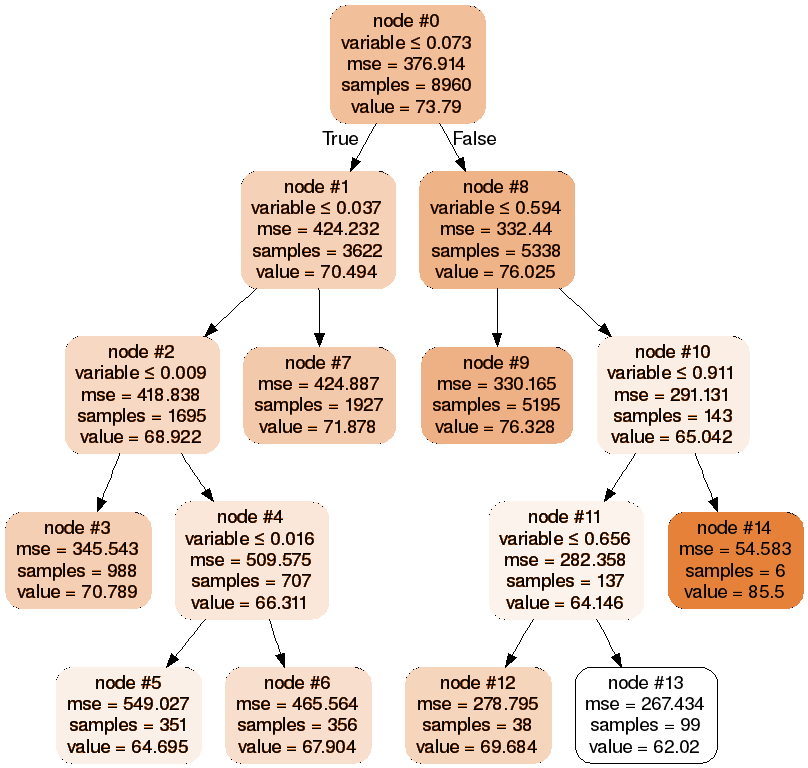

Training tree for reviews_last_30_days


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
18,0.000694,0.000240,-358.836895,-357.152482,mse,0.175,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-356.631622,-358.043886,-358.950878,-357.132406,-360.928884,-356.281154,0.000027,3.951328e-06,1.756152,0.719772
16,0.000689,0.000234,-358.871874,-357.215252,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",2,-356.736548,-358.232195,-358.950878,-357.132406,-360.928884,-356.281154,0.000015,4.895167e-06,1.712378,0.798660
17,0.000686,0.000236,-358.871874,-357.215252,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",2,-356.736548,-358.232195,-358.950878,-357.132406,-360.928884,-356.281154,0.000023,6.220243e-06,1.712378,0.798660
15,0.000678,0.000234,-359.050051,-357.643794,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-356.084844,-358.699364,-360.137054,-357.950863,-360.928884,-356.281154,0.000023,1.969260e-06,2.121663,1.010826
14,0.000698,0.000235,-359.050051,-357.643794,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-356.084844,-358.699364,-360.137054,-357.950863,-360.928884,-356.281154,0.000018,2.338718e-06,2.121663,1.010826
20,0.002069,0.000810,-359.229684,-356.703287,mse,0.1,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",6,-357.472505,-357.010970,-359.332265,-356.959530,-360.884837,-356.139363,0.000146,3.602516e-04,1.394927,0.399308
19,0.002000,0.000866,-359.307691,-356.795554,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",7,-357.662465,-357.145978,-359.332265,-356.959530,-360.928884,-356.281154,0.000893,5.371339e-04,1.333586,0.371615
9,0.000666,0.000232,-359.683986,-357.861840,mse,0.45,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-356.084844,-358.699364,-360.137054,-357.950863,-362.831114,-356.935293,0.000013,7.370010e-07,2.772650,0.722925
10,0.004693,0.000250,-359.683986,-357.861840,mse,0.425,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-356.084844,-358.699364,-360.137054,-357.950863,-362.831114,-356.935293,0.005671,2.308300e-05,2.772650,0.722925
11,0.000666,0.000235,-359.683986,-357.861840,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-356.084844,-358.699364,-360.137054,-357.950863,-362.831114,-356.935293,0.000014,7.772917e-06,2.772650,0.722925


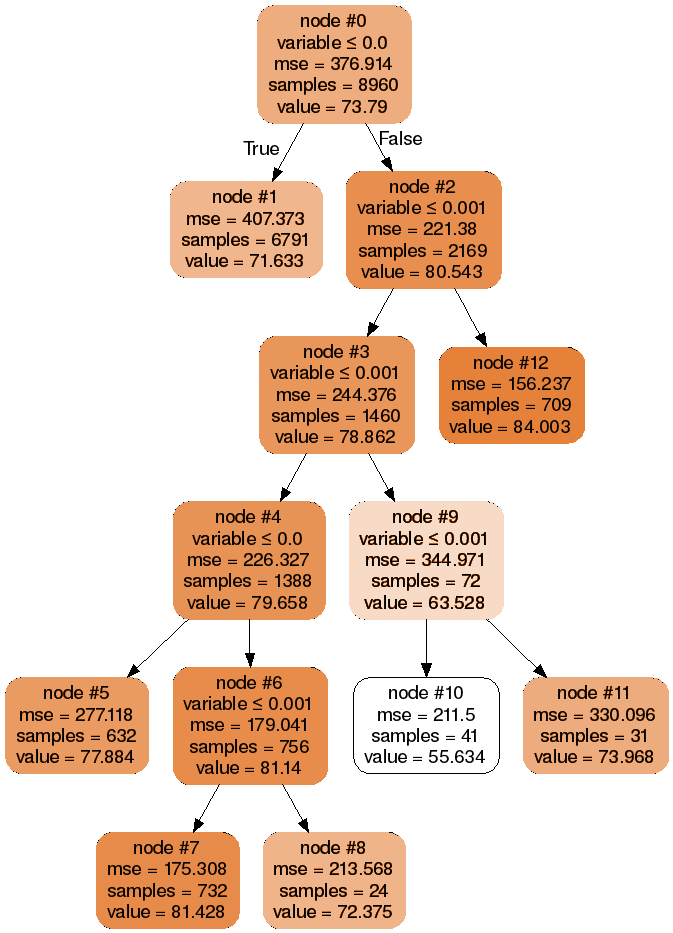

Training tree for reviews_all_time


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
11,0.003046,0.000855,-355.212284,-352.753676,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-353.735843,-353.686947,-356.422552,-351.88483,-355.478545,-352.689252,0.000398,0.000390,1.112941,0.737120
14,0.001414,0.000417,-355.212284,-352.753676,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-353.735843,-353.686947,-356.422552,-351.88483,-355.478545,-352.689252,0.000263,0.000116,1.112941,0.737120
13,0.001286,0.000387,-355.212284,-352.753676,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-353.735843,-353.686947,-356.422552,-351.88483,-355.478545,-352.689252,0.000245,0.000074,1.112941,0.737120
12,0.001417,0.000426,-355.212284,-352.753676,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-353.735843,-353.686947,-356.422552,-351.88483,-355.478545,-352.689252,0.000264,0.000110,1.112941,0.737120
7,0.001065,0.000264,-355.665281,-352.893202,mse,0.5,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",5,-353.735843,-353.686947,-356.422552,-351.88483,-356.837840,-353.107829,0.000052,0.000007,1.374925,0.751201
10,0.002597,0.000549,-355.665281,-352.893202,mse,0.425,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",5,-353.735843,-353.686947,-356.422552,-351.88483,-356.837840,-353.107829,0.000753,0.000218,1.374925,0.751201
8,0.001012,0.000261,-355.665281,-352.893202,mse,0.475,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",5,-353.735843,-353.686947,-356.422552,-351.88483,-356.837840,-353.107829,0.000023,0.000005,1.374925,0.751201
9,0.000999,0.000295,-355.665281,-352.893202,mse,0.45,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",5,-353.735843,-353.686947,-356.422552,-351.88483,-356.837840,-353.107829,0.000020,0.000054,1.374925,0.751201
6,0.001020,0.000261,-355.665281,-352.893202,mse,0.55,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",5,-353.735843,-353.686947,-356.422552,-351.88483,-356.837840,-353.107829,0.000023,0.000004,1.374925,0.751201
5,0.001056,0.000307,-355.665281,-352.893202,mse,0.575,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",5,-353.735843,-353.686947,-356.422552,-351.88483,-356.837840,-353.107829,0.000023,0.000057,1.374925,0.751201


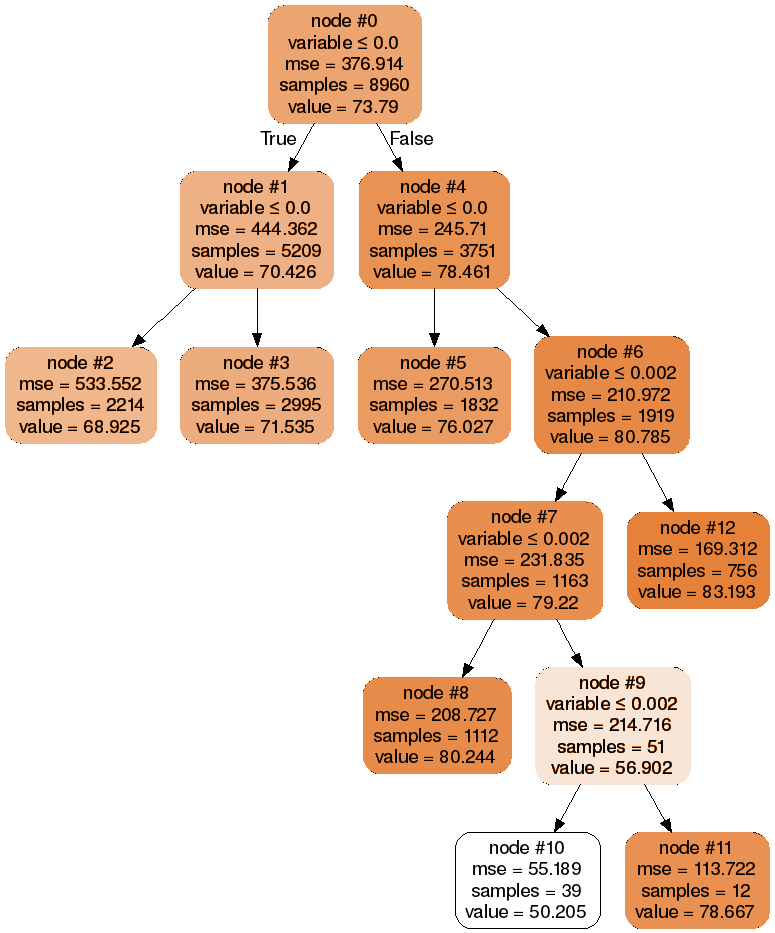

Training tree for release_date


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
5,0.006696,0.000289,-370.912422,-369.450962,mse,0.575,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-366.791709,-370.635321,-371.507708,-369.896071,-374.439029,-367.821495,0.007936,0.000028,3.150172,1.191077
2,0.001288,0.000295,-370.956808,-369.645276,mse,0.65,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",2,-366.791709,-370.635321,-371.507708,-369.896071,-374.572217,-368.404436,0.000014,0.000002,3.200093,0.927860
3,0.001079,0.000563,-370.956808,-369.645276,mse,0.625,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",2,-366.791709,-370.635321,-371.507708,-369.896071,-374.572217,-368.404436,0.000056,0.000438,3.200093,0.927860
4,0.001125,0.000264,-370.956808,-369.645276,mse,0.6,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",2,-366.791709,-370.635321,-371.507708,-369.896071,-374.572217,-368.404436,0.000119,0.000018,3.200093,0.927860
6,0.001091,0.000252,-371.151064,-369.259984,mse,0.55,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",5,-366.791709,-370.635321,-372.223556,-369.323134,-374.439029,-367.821495,0.000054,0.000003,3.212723,1.149607
8,0.001107,0.000253,-371.273340,-368.748593,mse,0.475,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",6,-366.783856,-370.128505,-372.226305,-368.817119,-374.811044,-367.300154,0.000043,0.000005,3.345570,1.155686
7,0.005144,0.000266,-371.273340,-368.748593,mse,0.5,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",6,-366.783856,-370.128505,-372.226305,-368.817119,-374.811044,-367.300154,0.005714,0.000021,3.345570,1.155686
9,0.001111,0.000253,-371.273340,-368.748593,mse,0.45,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",6,-366.783856,-370.128505,-372.226305,-368.817119,-374.811044,-367.300154,0.000052,0.000006,3.345570,1.155686
12,0.001174,0.000263,-371.291585,-368.061584,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",9,-366.207917,-369.292976,-372.856972,-367.591623,-374.811044,-367.300154,0.000072,0.000003,3.682441,0.878818
10,0.001125,0.000261,-371.379840,-368.603396,mse,0.425,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",10,-366.783856,-370.128505,-372.545769,-368.381527,-374.811044,-367.300154,0.000045,0.000008,3.379127,1.165279


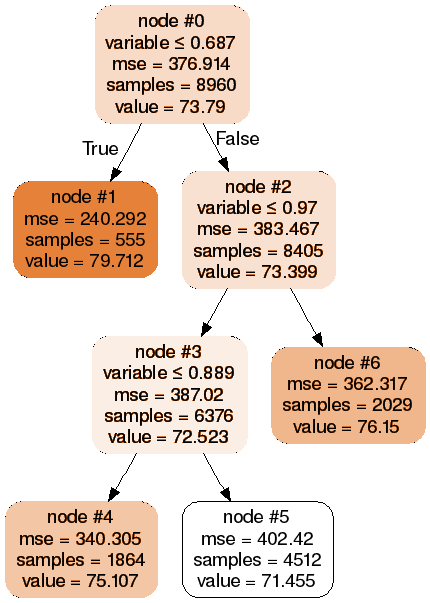

Training tree for num_achievements


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
9,0.000922,0.000285,-363.633383,-362.661244,mse,0.45,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-364.930135,-362.522458,-364.805854,-361.726345,-361.163334,-363.734928,0.000125,4.915446e-05,1.747033,0.825852
7,0.002351,0.001090,-363.633383,-362.661244,mse,0.5,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-364.930135,-362.522458,-364.805854,-361.726345,-361.163334,-363.734928,0.002208,1.111794e-03,1.747033,0.825852
11,0.000848,0.000307,-363.633383,-362.661244,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-364.930135,-362.522458,-364.805854,-361.726345,-361.163334,-363.734928,0.000099,5.609320e-05,1.747033,0.825852
10,0.000725,0.000239,-363.633383,-362.661244,mse,0.425,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-364.930135,-362.522458,-364.805854,-361.726345,-361.163334,-363.734928,0.000017,8.104673e-07,1.747033,0.825852
8,0.000879,0.000318,-363.633383,-362.661244,mse,0.475,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-364.930135,-362.522458,-364.805854,-361.726345,-361.163334,-363.734928,0.000122,5.519412e-05,1.747033,0.825852
16,0.000811,0.000251,-363.778577,-362.134471,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",6,-364.062642,-362.285702,-365.177568,-361.090268,-362.094957,-363.027444,0.000010,1.236308e-06,1.274368,0.798046
17,0.000935,0.000279,-363.778577,-362.134471,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",6,-364.062642,-362.285702,-365.177568,-361.090268,-362.094957,-363.027444,0.000074,1.494808e-05,1.274368,0.798046
12,0.000841,0.000253,-363.818569,-362.529609,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-364.930135,-362.522458,-365.361348,-361.331442,-361.163334,-363.734928,0.000127,1.045665e-05,1.885457,0.981232
13,0.000747,0.000244,-363.818569,-362.529609,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-364.930135,-362.522458,-365.361348,-361.331442,-361.163334,-363.734928,0.000022,5.993750e-06,1.885457,0.981232
6,0.000703,0.000235,-363.933407,-362.840901,mse,0.55,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",10,-365.830104,-363.061429,-364.805854,-361.726345,-361.163334,-363.734928,0.000015,3.164976e-06,2.002557,0.834696


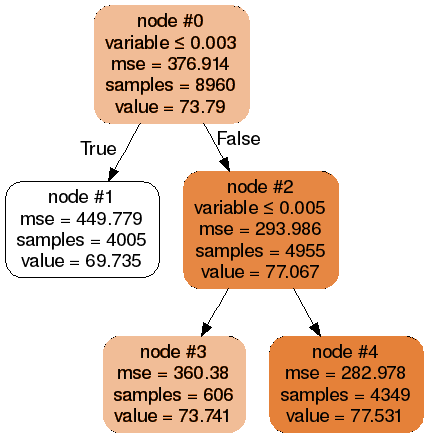

In [13]:
continuous_vars = (
    'full_price',
    'reviews_last_30_days',
    'reviews_all_time',
    'release_date',
    'num_achievements',
)

pipelines = {}

for var in continuous_vars:
    print('Training tree for {}'.format(var))
    pipeline = find_optimal_bins(df_train, y_train, var, display_report=True)
    pipelines[var] = pipeline
    clf = pipeline.named_steps.clf
    draw_tree(clf, var)
    
    for df in (df_train, df_test):
        df['{}_binned'.format(var)] = apply_bins(pipeline, var, df)

# Apply various transformations to continuous variables

Apply some common transformations to continuous variables in case they have a nonlinear relationship with the outcome.

In [14]:
for var in continuous_vars:
    for df in (df_train, df_test):
        df['{}_squared'.format(var)] = np.square(df[var])
        # Add two for log transform to prevent numeric warnings
        df['{}_log'.format(var)] = np.log(df[var]+2)
        df['{}_loglog'.format(var)] = np.log(df['{}_log'.format(var)])
        df['{}_sqrt'.format(var)] = np.sqrt(df[var])
        df['{}_indicator'.format(var)] = df[var].apply(lambda x: 1 if x > 0
                                                       else 0)
        
        for winsor_pctile in (90, 95, 99):
            winsor_threshold = np.percentile(df[var], winsor_pctile)
            df['{}_winsor{}'.format(var, winsor_pctile)] = df[var].apply(
                lambda x: winsor_threshold if x > winsor_threshold
                else x)

# Run linear regression model on full dataset with all engineered features

Use the engineered features in a regression model.

In [20]:
pipeline = sklearn.pipeline.Pipeline((
    ('scaler', sklearn.preprocessing.MinMaxScaler()),
    ('clf', sklearn.linear_model.Lasso(random_state=7, max_iter=100000)),
))

param_grid = {
    'clf__alpha': [0.1, 0.05, 0.025, 0.01, 0.0075, 0.006, 0.005, 0.004, 0.003, 0.0025]
}

grid_search = sklearn.model_selection.GridSearchCV(
    pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
    n_jobs=-1, cv=3, return_train_score=True)

grid_search.fit(df_train, y_train)

display_cv_results(grid_search)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
7,24.104710,0.108303,-271.180000,-240.777938,0.004,{'clf__alpha': 0.004},1,-274.380123,-239.827393,-270.530775,-241.145749,-268.628247,-241.360670,7.091104,0.041017,2.392590,0.677839
6,69.281708,0.128238,-271.247752,-242.821291,0.005,{'clf__alpha': 0.005},2,-274.489233,-241.580288,-270.539631,-243.085113,-268.713544,-243.798472,13.231758,0.038593,2.410438,0.924585
4,14.516610,0.137775,-271.302236,-247.342820,0.0075,{'clf__alpha': 0.0075},3,-275.014013,-245.915656,-271.391077,-247.891650,-267.500343,-248.221155,11.992609,0.022930,3.068001,1.018084
5,25.570754,0.124552,-271.416545,-244.875570,0.006,{'clf__alpha': 0.006},4,-274.953957,-243.616010,-271.171008,-245.390750,-268.123569,-245.619950,27.720171,0.034232,2.793817,0.895545
3,8.778527,0.133722,-271.753681,-251.116420,0.01,{'clf__alpha': 0.01},5,-275.819891,-249.572969,-272.057454,-251.640432,-267.382233,-252.135858,2.858664,0.039291,3.451255,1.109967
8,21.107679,0.169735,-271.877278,-239.074518,0.003,{'clf__alpha': 0.003},6,-274.636013,-238.211346,-271.069828,-239.445780,-269.925341,-239.566429,3.555939,0.045481,2.006051,0.612339
9,18.353726,0.074397,-272.403477,-238.266789,0.0025,{'clf__alpha': 0.0025},7,-274.966200,-237.364511,-271.405146,-238.678071,-270.838561,-238.757786,0.052434,0.008535,1.826971,0.638837
2,5.829409,0.099693,-278.967866,-266.871824,0.025,{'clf__alpha': 0.025},8,-283.318650,-264.645696,-280.155351,-267.030353,-273.427742,-268.939423,4.904054,0.004152,4.124231,1.756487
1,1.557008,0.114920,-286.001834,-278.826460,0.05,{'clf__alpha': 0.05},9,-289.896263,-276.089685,-286.351571,-277.955654,-281.756248,-282.434041,0.582845,0.011455,3.332246,2.662260
0,1.231518,0.181598,-296.419085,-291.622778,0.1,{'clf__alpha': 0.1},10,-300.284916,-289.288141,-295.637508,-291.344299,-293.333799,-294.235895,0.166386,0.029154,2.891027,2.029488


# Visualize model performance

Visualizing regression results in a high-dimensional space is tricky, so we'll try to find a few ways to look at the predictions.

Plot the residuals to see if their distribution appears to be random.

,prediction,residual
steam_app_id,,


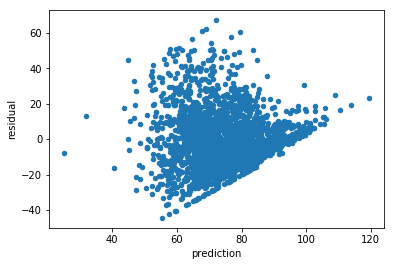

In [21]:
predictions = grid_search.predict(df_test)
residuals = predictions - y_test

residual_df = pd.DataFrame({'prediction': predictions, 'residual': residuals})

# There are a few (3) extreme outliers due to some highly inflated coefficients; ignore them or
# the graphs are too zoomed out to see anything
# Hopefully these extreme cases will go away when we use a more powerful model
display(residual_df[(residual_df['prediction'] >= 150) | (residual_df['prediction'] < 0)])

residual_df = residual_df[(residual_df['prediction'] <= 150) & (residual_df['prediction'] >= 0)]
residual_df.plot(x='prediction', y='residual', kind='scatter')

There are sharp lines along the boundaries of the actual data (since a proportion is bounded between 0 and 1), but the residuals otherwise look randomly distributed.

Plot the distribution of predicted values and distribution of actual values to see whether the model is closely approximating the real distribution.

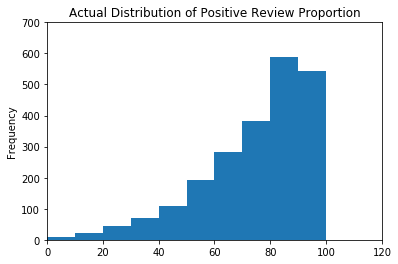

In [22]:
y_test.plot(kind='hist', title='Actual Distribution of Positive Review Proportion',
            ylim=(0, 700), xlim=(0,120))

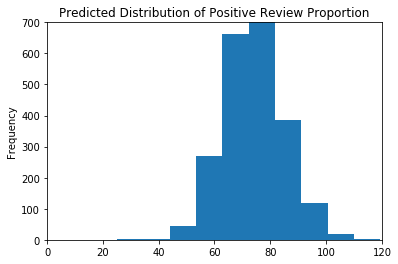

In [23]:
residual_df['prediction'].plot(kind='hist', title='Predicted Distribution of Positive Review Proportion',
                              ylim=(0, 700), xlim=(0, 120))

The distributions peak around the same area, but the assumption of a normal distribution inherent in ordinary least-squares regression is clearly incorrect.  We hope to more accurately match the true data distribution using more advanced techniques later.

Finally, check the R^2 value for our model on our test dataset.

In [24]:
grid_search.best_estimator_.named_steps.clf.score(df_test, y_test)

-4.9205574727207901e+37

The value is huge because of a ton of variance in the test set that wasn't present in the training set.  Hopefully, we can improve on this with a better model.